In [1]:
# imports
from matplotlib import pyplot as plt
import pandas as pd
from hmmlearn import hmm
import sys
import time
sys.path.insert(1, '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/')


import cleaner
import filter

wsl = True

The following tables and images are from https://www.kaggle.com/code/jefmenegazzo/road-surface-type-classification

| Hardware       | Sensor         | Data                                 | Sampling Rate |
|----------------|----------------|--------------------------------------|---------------|
| HP Webcam HD-4110 | Camera      | 720p Video                           | 30 Hz         |
| Xiaomi Mi 8       | GPS         | Speed in m/s, latitude, longitude, etc. | 1 Hz       |
| MPU-9250          | Accelerometer | 3-axis acceleration in m/s²         | 100 Hz        |
| MPU-9250          | Gyroscope    | 3-axis rotation rate in deg/s        | 100 Hz        |
| MPU-9250          | Magnetometer | 3-axis ambient geomagnetic field in µT | 100 Hz       |
| MPU-9250          | Temperature  | Sensor temperature in ◦C              | 100 Hz       |

| DataSet | Vehicle              | Driver   | Scenario  | Distance |
|---------|----------------------|----------|-----------|----------|
| PVS 1   | Volkswagen Saveiro   | Driver 1 | Scenario 1| 13.81 km |
| PVS 2   | Volkswagen Saveiro   | Driver 1 | Scenario 2| 11.62 km |
| PVS 3   | Volkswagen Saveiro   | Driver 1 | Scenario 3| 10.72 km |
| PVS 4   | Fiat Bravo           | Driver 2 | Scenario 1| 13.81 km |
| PVS 5   | Fiat Bravo           | Driver 2 | Scenario 2| 11.63 km |
| PVS 6   | Fiat Bravo           | Driver 2 | Scenario 3| 10.73 km |
| PVS 7   | Fiat Palio           | Driver 3 | Scenario 1| 13.78 km |
| PVS 8   | Fiat Palio           | Driver 3 | Scenario 2| 11.63 km |
| PVS 9   | Fiat Palio           | Driver 3 | Scenario 3| 10.74 km |

| File                   | Description                                                                                       |
|------------------------|---------------------------------------------------------------------------------------------------|
| dataset_gps.csv        | GPS data, including latitude, longitude, altitude, speed, accuracy, etc.                         |
| dataset_gps_mpu_left.csv  | Inertial sensor data on the left side of the vehicle, combined with GPS data.                     |
| dataset_gps_mpu_right.csv | Inertial sensor data on the right side of the vehicle, combined with GPS data.                    |
| dataset_labels.csv       | Data classes for each sample data in the dataset (for both sides).                                  |
| dataset_mpu_left.csv     | Inertial sensor data on the left side of the vehicle.                                              |
| dataset_mpu_right.csv    | Inertial sensor data on the right side of the vehicle.                                             |

![Map of paths](./maps.png "All paths driven by the three drivers.")


In [2]:
if wsl:
    parent = '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/.data'
else:
    parent = ".data"
data_dict = cleaner.clean_dict(cleaner.load_data(parent))

In [3]:
cleaner.print_structure(data_dict)


  train: 
 	 t_gps: 
 		 PVS 1: (1458, 11)
 		 PVS 2: (1551, 11)
 		 PVS 3: (1316, 11)
 		 PVS 4: (1432, 11)
 		 PVS 5: (1263, 11)
 		 PVS 6: (915, 11)
 		 PVS 7: (1281, 11)
 		 PVS 8: (1134, 11)
 		 PVS 9: (999, 11)
 	 gps_mpu_left: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 		 PVS 7: (128548, 26)
 		 PVS 8: (123618, 26)
 		 PVS 9: (91555, 26)
 	 gps_mpu_right: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 		 PVS 7: (128548, 26)
 		 PVS 8: (123618, 26)
 		 PVS 9: (91555, 26)
 	 labels: 
 		 PVS 1: (144036, 14)
 		 PVS 2: (124684, 14)
 		 PVS 3: (105816, 14)
 		 PVS 4: (132492, 14)
 		 PVS 5: (133877, 14)
 		 PVS 6: (96279, 14)
 		 PVS 7: (128548, 14)
 		 PVS 8: (123618, 14)
 		 PVS 9: (91555, 14)
 	 folders: 9
  val: 
 	 t_gps: <class 'NoneType'>
 	 gps_mpu_left: <class 'NoneType'>
 	 g

In [ ]:
filter.add_smoothed_cols(data_dict)

In [5]:
start = 67000
end = 70000

test_right = data_dict["train"]["gps_mpu_right"]["PVS 1"]
test_left = data_dict["train"]["gps_mpu_left"]["PVS 1"]
test_gps = data_dict["train"]["t_gps"]["PVS 1"]
test_labels = data_dict["train"]["labels"]["PVS 1"]

In [6]:
test_labels.columns

Index(['paved_road', 'unpaved_road', 'dirt_road', 'cobblestone_road',
       'asphalt_road', 'no_speed_bump', 'speed_bump_asphalt',
       'speed_bump_cobblestone', 'good_road_left', 'regular_road_left',
       'bad_road_left', 'good_road_right', 'regular_road_right',
       'bad_road_right'],
      dtype='object')

In [20]:
# hmm data
hmm_train = test_left[['acc_z_dash_smooth']]
# hmm_right = test_right[['timestamp', 'speed', 'acc_x_dash_smooth',
#             'acc_y_dash_smooth', 'acc_z_dash_smooth', 'acc_x_above_smooth',
#             'acc_y_above_smooth', 'acc_z_above_smooth', 'acc_x_below_smooth',
#             'acc_y_below_smooth', 'acc_z_below_smooth']]
# hmm_train = pd.merge(test_left, test_right, on='timestamp', suffixes=('_left', '_right'))

X = hmm_train.values


# hmm labels
hmm_true = test_labels[['paved_road', 'unpaved_road', 'dirt_road', 'cobblestone_road', 'asphalt_road']]
# hmm_true['timestamp'] = hmm_train['timestamp']

# HMM

I got it to run (it turns out that you can only include one series as your input data) but it doesn't work. I think the HMM decided that zeros are local minimums or values below a threshold and pretty much everything else is ones.

In [21]:
nc = 3
nf = hmm_train.shape[1]

model = hmm.GaussianHMM(n_components=nc, 
                    covariance_type="tied",
                    n_iter=200, 
                    tol=1e-4)
                    
print("Fitting")
start = time.perf_counter()
model.fit(X)
print(f"Fitting took {time.perf_counter() - start} seconds")

pi = model.startprob_
A = model.transmat_.T

Fitting
Fitting took 4.750012200000128 seconds


In [22]:
predicted_labels = model.predict(X)

Switches: 1634
Lenght of labels: 144036
Ratio: 0.0113443861256908


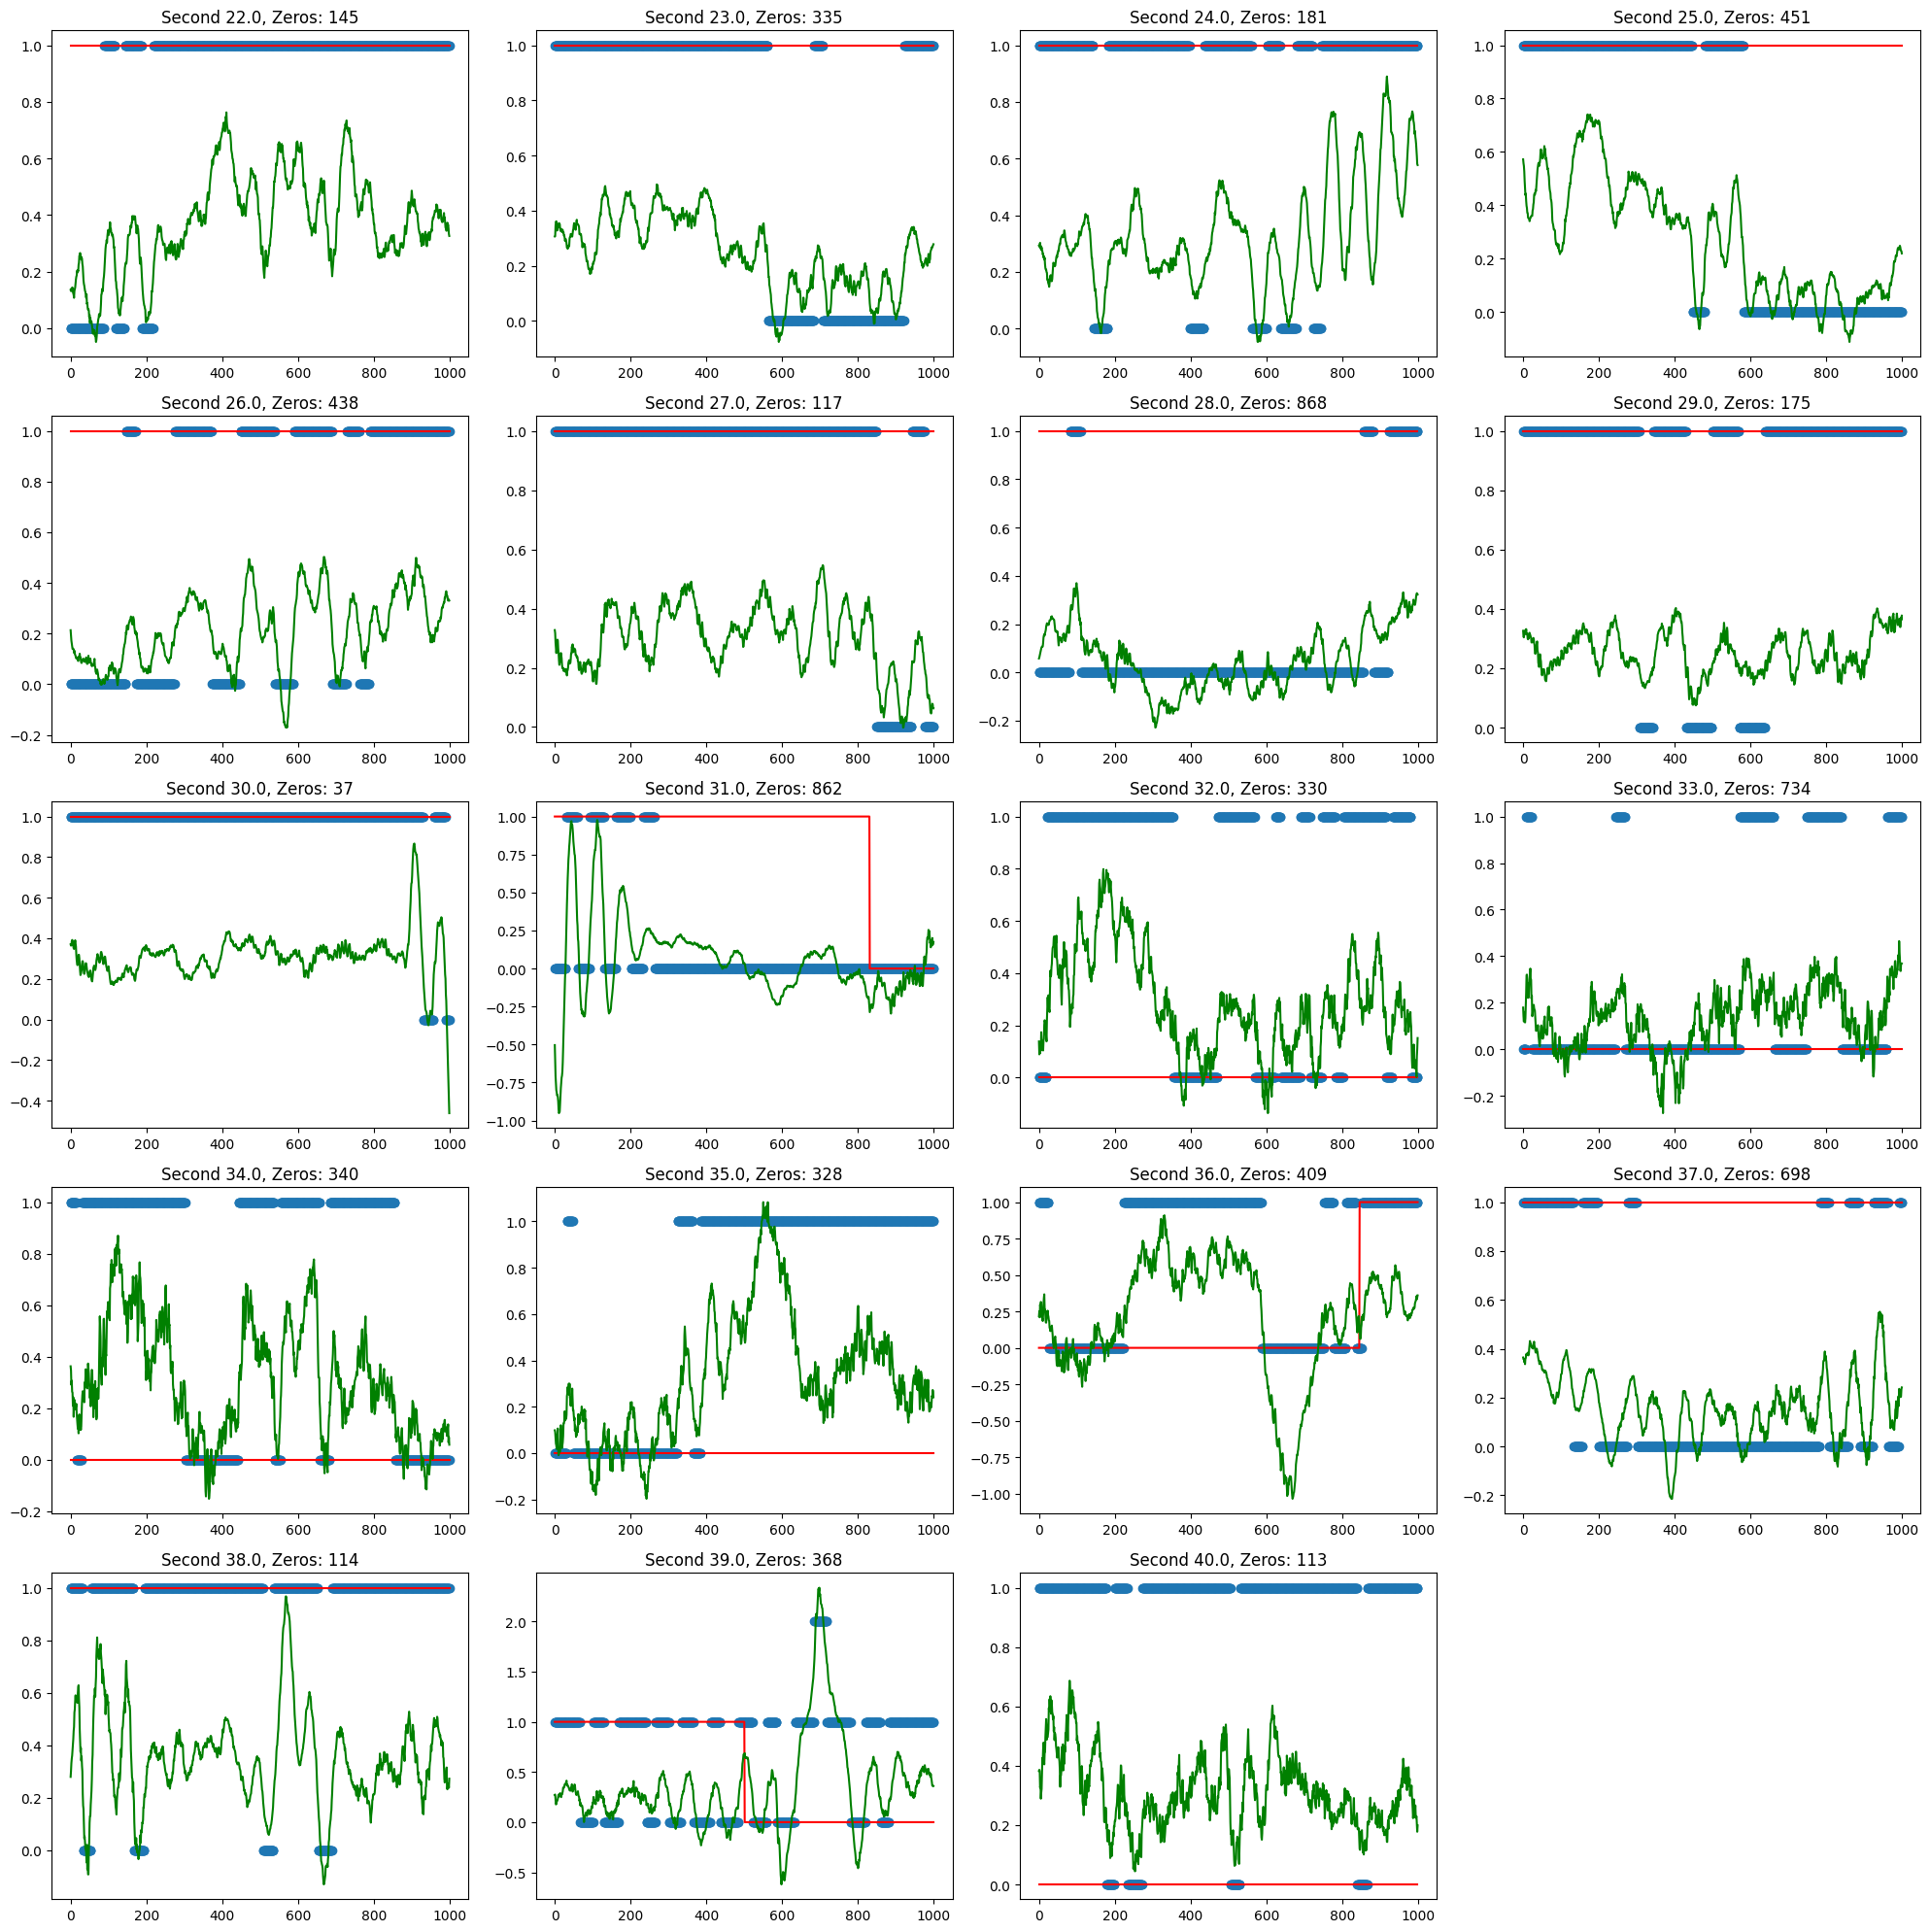

In [60]:
# how many times does predicted_labels switch form 0 to 1
switches = 0
for i in range(1, len(predicted_labels)):
    if predicted_labels[i] != predicted_labels[i-1]:
        switches += 1

print(f"Switches: {switches}")
print(f"Lenght of labels: {len(predicted_labels)}") 
print(f"Ratio: {switches/len(predicted_labels)}")

# plot the predicted labels
import numpy as np
start = 20000
end = 21000
diff = 1000
plt.figure(figsize=(20, 20))
p = 1
while p < 20:
    plt.subplot(5, 4, max(p,1))
    p += 1
    start += diff
    end += diff   
    a = predicted_labels[start:end]
    # count how many zeros
    zeros = np.count_nonzero(a == 0)
    # print("Zeros: ", zeros)
    # print("P:", p)
    if zeros == 0:
        p -= 1
        continue
    plt.scatter(np.arange(diff), predicted_labels[start:end])
    plt.plot(np.arange(diff), hmm_true['paved_road'][start:end], color='red')
    plt.plot(np.arange(diff), X[start:end, 0]-9.5, color='green')
    plt.title(f"Second {end/1000}, Zeros: {zeros}")
    # remove axis ticks
    # plt.xticks([])
    # plt.yticks([])

# reduce space between subplots
plt.tight_layout()
plt.show()